In [1]:
import panel
import joblib
import pyvista as pv
import zipfile
import numpy as np
import pandas as pd
import glob
import os
import scooby

## Velocidad

In [2]:
vel = np.load('seg_eage_salt_model/salt3D(26x26x10).npy')

In [3]:
# New dimensions
nx, ny, nz = 26, 26, 10

# Create nodal values along each axis
origin = [    0.,     0., -4200.]
xrng = np.linspace(origin[0], nx*20*26., nx+1)
yrng = np.linspace(origin[1], ny*20*26., ny+1)
zrng = np.linspace(origin[2], 0.,  nz+1)

# Pass those nodal values to the RectilinearGrid
mesh = pv.RectilinearGrid(xrng, yrng, zrng)

# Add data to the mesh
mesh['vel'] = vel.ravel('F')

mesh

RectilinearGrid (0x281b68bd840)
  N Cells:	6760
  N Points:	8019
  X Bounds:	0.000e+00, 1.352e+04
  Y Bounds:	0.000e+00, 1.352e+04
  Z Bounds:	-4.200e+03, 0.000e+00
  Dimensions:	27, 27, 11
  N Arrays:	1

In [4]:
dparams = {'cmap': 'viridis', 'show_edges': False, 'clim': mesh.get_data_range()}
box = mesh.outline()

In [5]:
# Get three corss-sectional slices
slices = mesh.slice_orthogonal(x=7000, y=6000, z=-3200)
slices

MultiBlock (0x281b038fd60)
  N Blocks:	3
  X Bounds:	0.000, 13520.000
  Y Bounds:	0.000, 13520.000
  Z Bounds:	-4200.000, 0.000

In [6]:
# Extract the salt body by scalar values
# and decimate it's boundary with a 90% reduction target
# Why decimate it? it makes the rendering more easily shareable online
# Also, we smooth it over 50 iteration to make it a bit cleaner
rmin, rmax = 4480.0, 4484.0
salt_body = mesh.threshold([rmin, rmax]).decimate_boundary(0.90).smooth(50)
# Fill with scalar values on the surface
salt_body['vel'] = np.full(salt_body.n_cells, rmin)
salt_body

PolyData (0x281b4ffe440)
  N Cells:	66
  N Points:	34
  N Strips:	0
  X Bounds:	4.131e+03, 9.831e+03
  Y Bounds:	3.418e+03, 8.421e+03
  Z Bounds:	-3.352e+03, -1.055e+03
  N Arrays:	1

c:\Users\CR_98\miniconda3\envs\main1\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


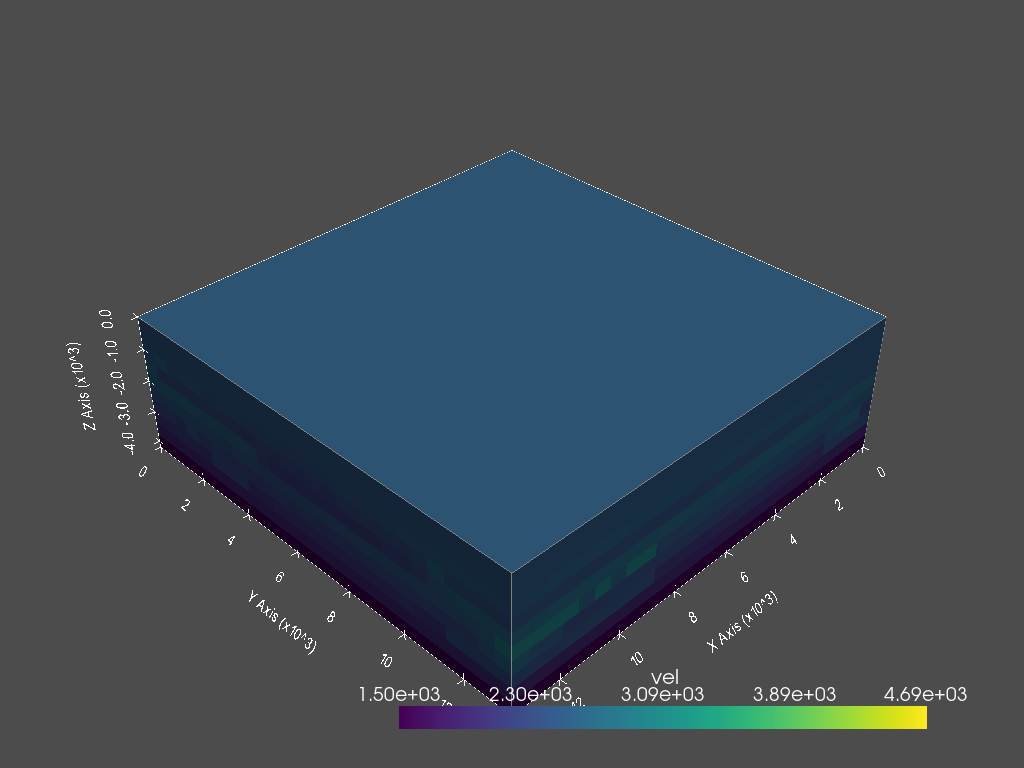

In [29]:
# Display the data
p = pv.Plotter(notebook=True)
p.add_mesh(mesh)
p.add_mesh(box, color='grey')
p.show_grid()
p.show()

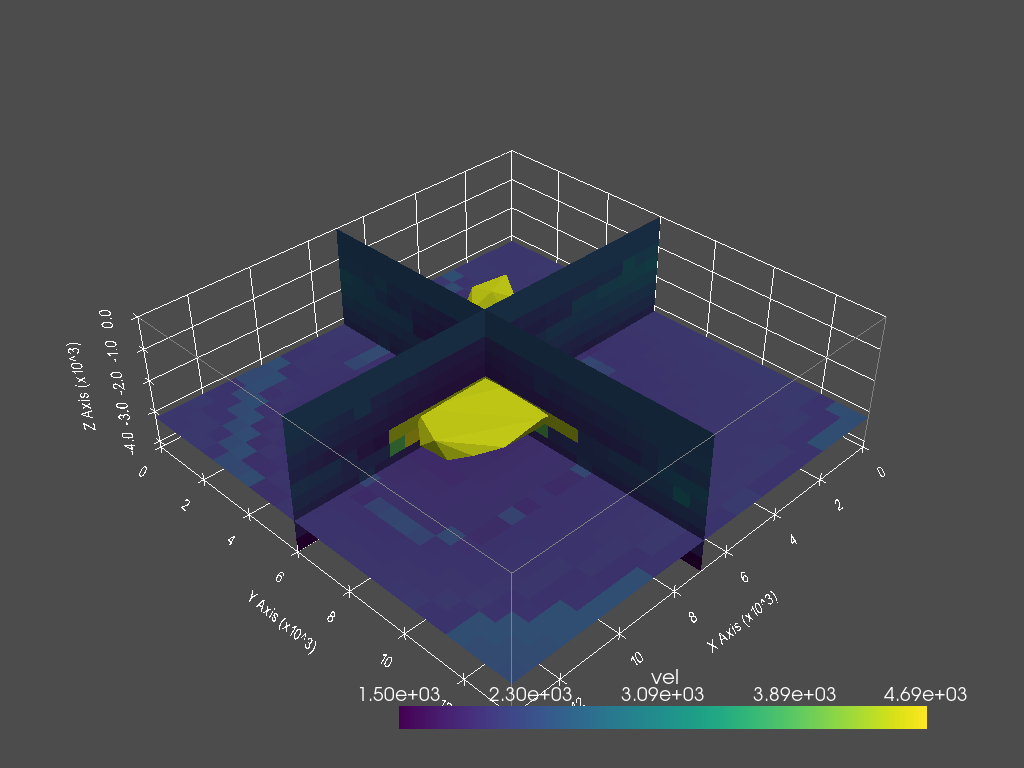

In [8]:
# Display the data
p = pv.Plotter(notebook=True)
p.add_mesh(slices, **dparams)
p.add_mesh(salt_body, **dparams)
p.add_mesh(box, color='grey')
p.show_grid()
p.show()

## Lectura de superficies

In [9]:
SURF_PATH = 'seg_eage_salt_model/SURFACES/'
if not os.path.isdir(SURF_PATH):
    raise RuntimeError('Yo! Place the `SURFACES` folder in the `data` directory.')
surface_files = glob.glob(os.path.join(SURF_PATH, '*.ts'))

faults = pv.MultiBlock()
layers = pv.MultiBlock()
horizons = pv.MultiBlock()
additional = pv.MultiBlock()

for file in surface_files:
    name = os.path.basename(file).replace('.ts', '').lower()
    table = pd.read_table(file, names=['type', 'a', 'b', 'c', 'd', 'e'], 
                          delim_whitespace=True)
    nodes = table[table['type'].str.contains('VRTX')][['b', 'c', 'd']].values
    # THE SEG/EAGE salt-model uses positive z downwards; so...
    # Flip the Z-coordinate reference
    nodes[:, -1] *= -1
    tris = table[table['type'] == 'TRGL'][['a', 'b', 'c']].values.astype(int) - 1
    faces = np.hstack(np.c_[np.full(len(tris), 3), tris])
    surf = pv.PolyData(nodes, faces)
    if name.startswith('fault'):
        faults[name] = surf
    elif name.startswith('layer'):
        layers[name] = surf
    elif name.startswith('hrz'):
        horizons[name] = surf
    else:
        additional[name] = surf
print('Done.')

Done.


In [10]:
faults

MultiBlock (0x281b3eea020)
  N Blocks:	12
  X Bounds:	-152.439, 13871.951
  Y Bounds:	-152.439, 13871.951
  Z Bounds:	-4001.816, -57.005

In [14]:
faults.save('seg_eage_salt_model/faults.vtm')
faults1 = pv.get_reader('seg_eage_salt_model/faults.vtm')
meshfaults = faults1.read()

In [22]:
faults.save('seg_eage_salt_model/layers.vtm') 
layers

MultiBlock (0x281bcbcd600)
  N Blocks:	16
  X Bounds:	-152.439, 14049.754
  Y Bounds:	-166.391, 13871.951
  Z Bounds:	-3658.536, -1824.837

In [23]:
faults.save('seg_eage_salt_model/horizons.vtm') 
horizons

MultiBlock (0x281bcbcd660)
  N Blocks:	5
  X Bounds:	-153.234, 13871.951
  Y Bounds:	-213.812, 13871.951
  Z Bounds:	-3409.834, -38.107

In [12]:
# Mesh
# Dimensions
# nx, ny, nz = 676, 676, 210
# Create nodal values along each axis
# origin = [    0.,     0., -4200.]
# xrng = np.linspace(origin[0], nx*20., nx+1)
# yrng = np.linspace(origin[1], ny*20., ny+1)
# zrng = np.linspace(origin[2], 0.,  nz+1)
# Pass those nodal values to the RectilinearGrid
# mesh = pv.RectilinearGrid(xrng, yrng, zrng)

In [13]:
# Extract the salt body by scalar values
# and decimate it's boundary with a 90% reduction target
# Why decimate it? it makes the rendering more easily shareable online
# Also, we smooth it over 50 iteration to make it a bit cleaner
# rmin, rmax = 4480.0, 4484.0
# salt_body = mesh.threshold([rmin, rmax]).decimate_boundary(0.90).smooth(50)
# Fill with scalar values on the surface
# salt_body['vel'] = np.full(salt_body.n_cells, rmin)
# salt_body

## Fallas y el cuerpo salino

c:\Users\CR_98\miniconda3\envs\main1\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


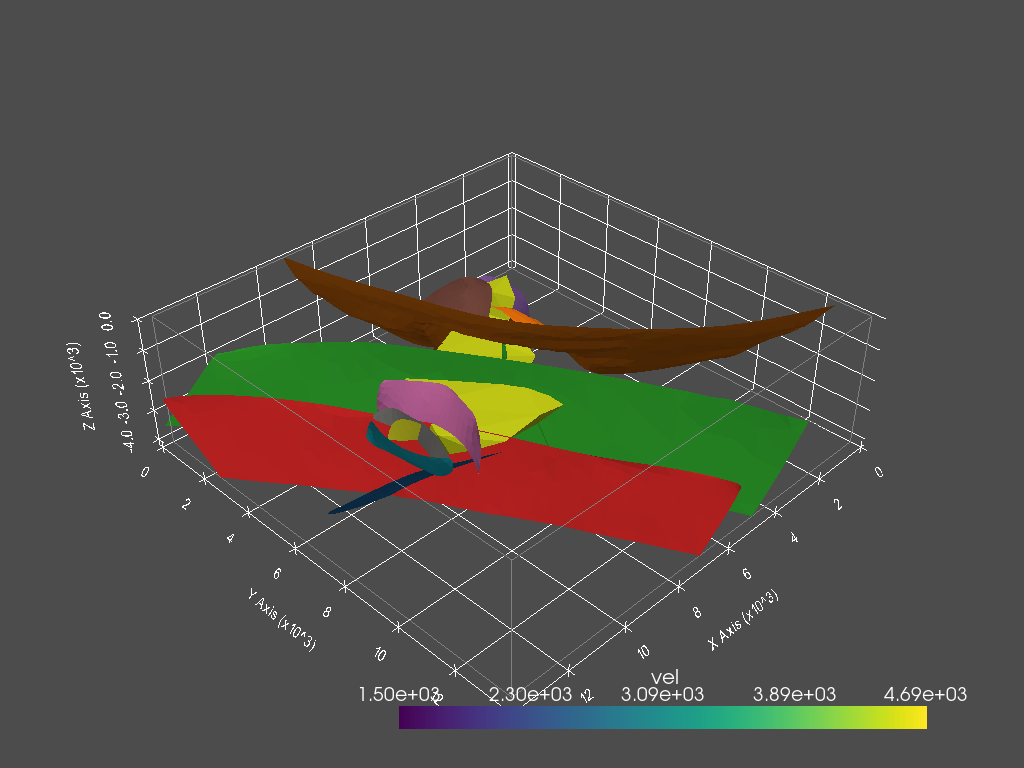

In [28]:
# Display the faults and the salt body
p = pv.Plotter(notebook=True)
p.add_mesh(meshfaults, multi_colors=True) # se grafican las fallas a partir del archivo vtp
p.add_mesh(salt_body, **dparams)
p.add_mesh(box, color='grey')
p.show_grid()
p.show()

## Capas y el cuerpo salino

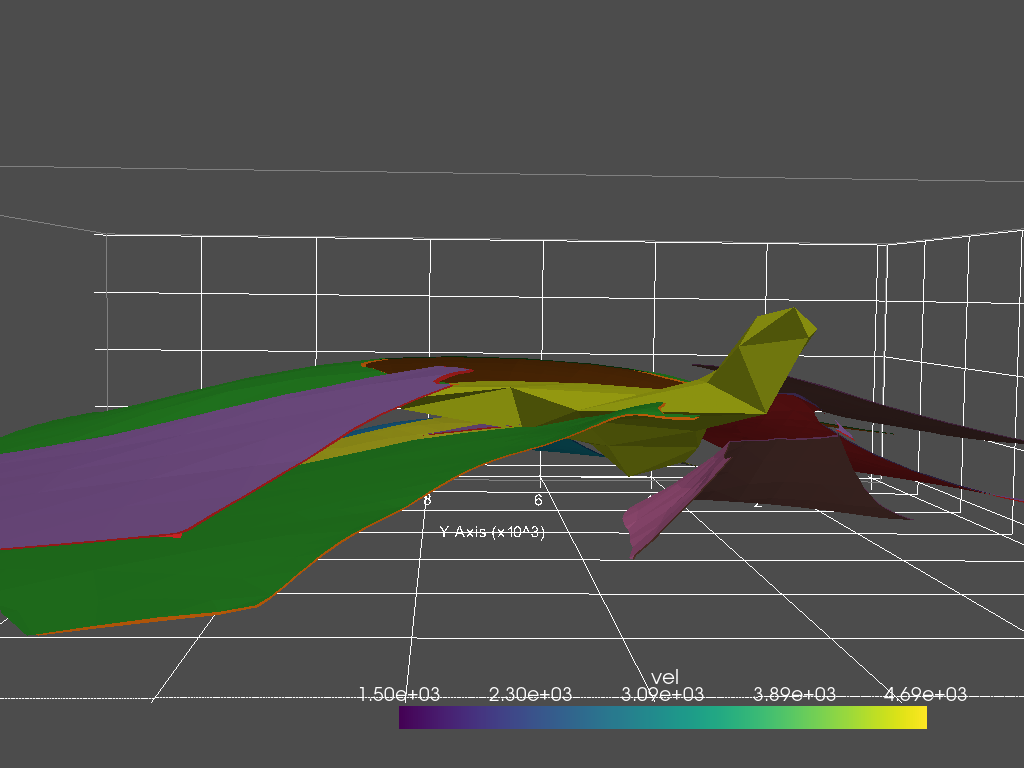

In [15]:
# Display the faults and the salt body
p = pv.Plotter(notebook=True)
p.add_mesh(layers, multi_colors=True)
p.add_mesh(salt_body, **dparams)
p.add_mesh(box, color='grey')
p.show_grid()
p.camera_position = [
 (-11386.44749303662, 7692.592539273874, -944.9898018895198),
 (6948.657622, 6852.7797304999995, -2100.0),
 (0.06324780761898185, 0.008332428153915016, 0.9979630681906281)]

p.show()

## Horizontes y el cuerpo salino

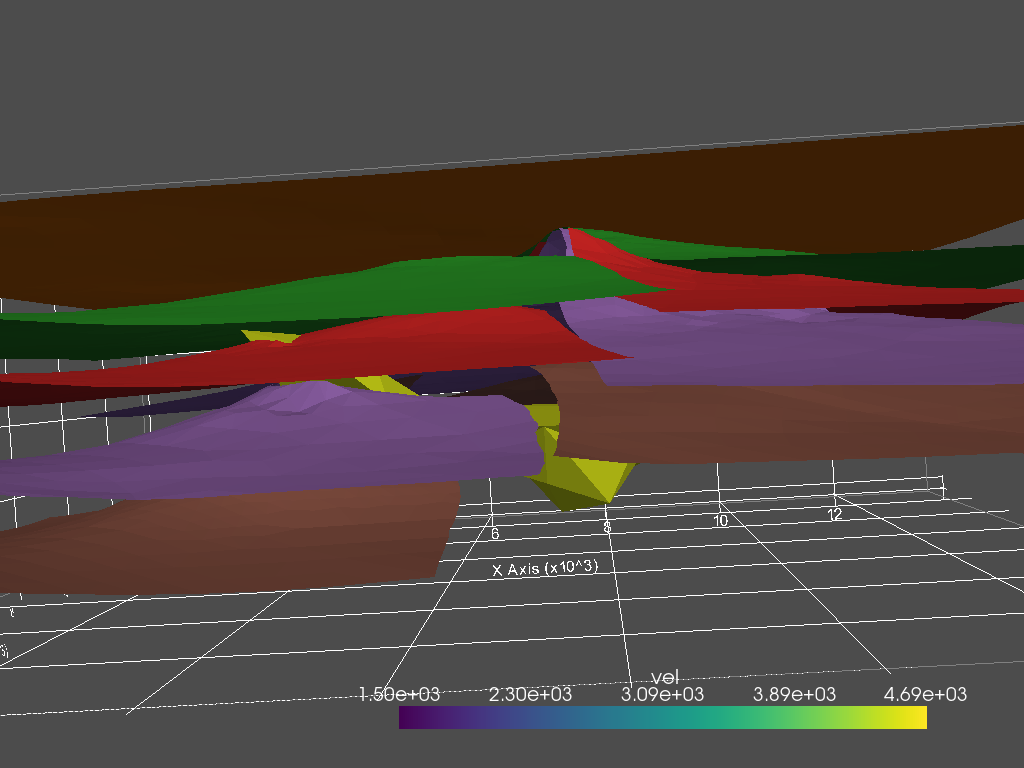

In [16]:
p = pv.Plotter(notebook=True)
p.add_mesh(horizons, multi_colors=True)
p.add_mesh(salt_body, **dparams)
p.add_mesh(box, color='grey')
p.show_grid()
p.camera_position = [
 (7792.44319915045, -11355.158057849327, -1672.991043821196),
 (6859.3583515, 6829.069745, -1849.053612),
 (0.06336336258536848, 0.012913248834522977, 0.9979069757679885)]
p.show()